In [2]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import ephem
from datetime import datetime, time, timedelta
from scipy import optimize
from mpl_toolkits.basemap import Basemap
from sys import getsizeof

import diurnal_config

# from diurnal_utils import *
%run diurnal_utils.py
from fetch_model_helper import *

# Notebook for exploring local CMIP6 data downloaded with `cmip6_downloader.py`

In [3]:
cmip_identifier = 'CMIP6'
# cmip_identifier = 'CMIP6'
start_date = '1985-01'
end_date = '2006-01'

# end_date = '1990-01'
# end_date = '1985-01'


In [4]:
cmip6_model_names = diurnal_config.cmip6_to_cmip5_map.keys()
cmip5_model_names = diurnal_config.cmip6_to_cmip5_map.values()



if cmip_identifier == 'CMIP6':
    all_model_names = list(cmip6_model_names)
    cmip_rel_dir = '/export/data1/cchristo/CMIP6_precip/pr_3hr_historical/'

elif cmip_identifier == 'CMIP5':
    all_model_names = list(cmip5_model_names)
    cmip_rel_dir = '/export/data1/cchristo/CMIP5_precip/pr_3hr_historical/'
    


In [5]:
model_name = 'IPSL-CM6A-LR' #'CanESM5'
if cmip_identifier == 'CMIP6':
    path_to_cmip_files =  get_path_to_desired_model_cmip6(cmip_rel_dir, 
                          desired_model= model_name,
                          desired_ensemble_member = ('r1i1p1f1', 'r1i1p2f1','r1i1p1f2'),
                          desired_grid_types = ('gn', 'gr', 'gr1', 'gr2'))
elif cmip_identifier == 'CMIP5':
    path_to_cmip_files = get_path_to_desired_model_cmip5(cmip_rel_dir, 
                      desired_model=model_name,
                      desired_ensemble_member = ('r1i1p1','r6i1p1','r2i1p1'))
# subset lat/lon and time
print('Opening data...')
# path_to_cmip_files = [cmip_rel_dir  + 'pr_3hr_IPSL-CM6A-LR_historical_r2i1p1f1_gr_195001010130-201412312230.nc',]
ds = xr.open_mfdataset(path_to_cmip_files, combine='by_coords')
ds = ds.sel(time = slice(start_date, end_date))
ds = ds.sel(lat= slice(-60, 60))

# perform diurnal analysis 
print('Performing diurnal analysis... ')
ds_sub = ds['pr'].to_dataset()

Opening data...
Performing diurnal analysis... 


In [112]:
# type(ds_sub['time'][0].item())
print(path_to_cmip_files)

['/export/data1/cchristo/CMIP6_precip/pr_3hr_historical/pr_3hr_IPSL-CM6A-LR_historical_r2i1p1f1_gr_195001010130-201412312230.nc']


In [33]:
ds_sub_ec_earth.time[0].item()

473391000000000000

In [35]:
ds_sub_ipsl.time[0].item()

473391000000000000

In [48]:
# ds_sub

## Timing Stats
#### 10min 55s - time_resolution_hours = 1
#### xxx - time_resolution_hours = 0.1

In [6]:
%%time
grid_time_resolution_hours = 3
time_resolution_hours = .2
field_id = 'pr'

hour_bins = np.arange(time_resolution_hours, 24 + time_resolution_hours, time_resolution_hours)
hour_bins = np.round(hour_bins, 2)
grid_hour_bins = np.arange(grid_time_resolution_hours, 24 + grid_time_resolution_hours, grid_time_resolution_hours)
grid_hour_bins = np.round(grid_hour_bins, 2)

lon_mesh, lat_mesh = np.meshgrid(ds['lon'].values, ds['lat'].values)
ds_seasons = ds.groupby('time.season')

mu_season = {}
sigma_season = {}
ampl_season = {}
phase_season = {}
ampl_cov_season = {}
phase__cov_season = {}
average_cycle_season = {}

for season_i, season_ds in ds_seasons:
    if season_i != 'DJF':
        break
    print(season_i)
    lst_da = compute_lst_array(season_ds, 
                               bin_interval = grid_time_resolution_hours, # time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    del lst_da
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

    #         field_season_mean = field_season_array.mean(axis = 0)

    # compute mu_ij
    #         mu_ij = np.zeros(field_season_array.shape[-2:])
    mu_ij = np.zeros(field_season_array.shape[-2:])
    #         sigma_ij = np.zeros((len(hour_bins),) + field_season_array.shape[-2:])

    f_bar_ks = {}
    for hour_i in grid_hour_bins:
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        f_bar_ks[hour_i] = f_bar_k
        mu_ij  += f_bar_k

    hour_means = np.stack(list(f_bar_ks.values()))
    average_cycle_season[season_i] = hour_means


    mu_ij = (1/len(grid_hour_bins))*mu_ij
    #         mu_ij = (1/8)*mu_ij
    mu_season[season_i] = mu_ij

    sigma_ij = np.zeros(field_season_array.shape[-2:])
    for hour_i in grid_hour_bins:
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_k[np.isnan(f_bar_k)] = 0
        sigma_ij += np.square(f_bar_k - mu_ij)

    sigma_ij = np.sqrt((1/(len(grid_hour_bins) - 1))*sigma_ij)
    #         sigma_ij = np.sqrt((1/7)*sigma_ij)
    #         sigma_ij = np.nanstd(sigma_ij, axis = 0)

    sigma_season[season_i] = sigma_ij

    lst_da = compute_lst_array(season_ds, 
                               bin_interval = time_resolution_hours,
                               bin_bool = True, 
                               lon_mesh = lon_mesh, 
                               lat_mesh = lat_mesh,
                               field_id = field_id)
    lst_array = lst_da.values
    del lst_da
    lst_array[lst_array == 0] = 24
    field_season_array = season_ds[field_id].values

    #         field_season_mean = field_season_array.mean(axis = 0)

    # compute hourly grid means needed for cos fit
    f_bar_ks = {}
    for ii in range(len(hour_bins)):
        hour_i = hour_bins[ii]
        masked_field = np.where(lst_array == hour_i, field_season_array, np.nan)

        # mean for a given season, LST
        f_bar_k = np.nanmean(masked_field, axis = 0)
        f_bar_ks[hour_i] = f_bar_k

    hour_means = np.stack(list(f_bar_ks.values()))

    print('Performing Cos Fit')
    #         res = cos_fit_grid(field_season_array, lst_array, hour_means, hour_bins)
    res = cos_fit_grid_average(hour_means, hour_bins)
    print('Finished Cos Fit')
    ampl_season[season_i], phase_season[season_i] = res[0], res[1]

    #TODO : Move this over! Should not do every iteration of the loop
    # make results into dataarrays
    out_ds = xr.Dataset()
    out_ds['mu_season'] = make_da_from_dict(mu_season, ds)
    out_ds['sigma_season'] = make_da_from_dict(sigma_season,ds)
    out_ds['ampl_season'] = make_da_from_dict(ampl_season, ds)
    out_ds['phase_season'] = make_da_from_dict(phase_season,ds)

    out_ds_means = xr.Dataset()
    out_ds_means = make_da_from_dict_time(average_cycle_season, ds, grid_hour_bins)
    out_ds_means = out_ds_means.to_dataset(name = field_id + '_mean')


DJF


100%|██████████| 15408/15408 [00:16<00:00, 920.06it/s]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
100%|██████████| 15408/15408 [00:17<00:00, 856.38it/s]
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice
  1%|          | 1/95 [00:00<00:13,  6.94it/s]

Performing Cos Fit


 59%|█████▉    | 56/95 [00:07<00:05,  7.40it/s]/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|██████████| 95/95 [00:13<00:00,  7.06it/s]

Finished Cos Fit
CPU times: user 6min 51s, sys: 2min 42s, total: 9min 34s
Wall time: 9min 37s


In [27]:
%run diurnal_utils.py
r1 = cos_fit_grid_average(hour_means, hour_bins)

100%|██████████| 172/172 [01:26<00:00,  1.99it/s]


/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/cchristo/.conda/envs/diurnal_research/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


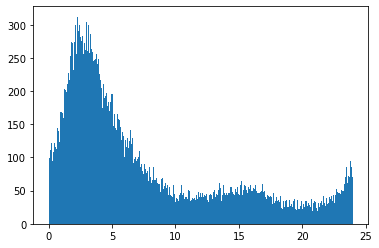

In [28]:
_ = plt.hist(r1[1].flatten(), bins = 1000)

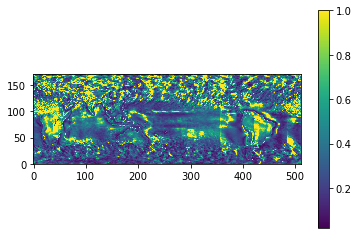

In [87]:
plt.imshow(np.sqrt(r1[3]), origin = 'lower', vmax = 1)
plt.colorbar()

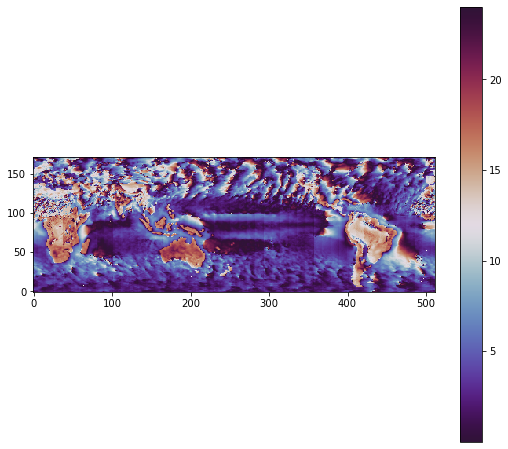

In [30]:
plt.figure(figsize = (9,8))
plt.imshow(r1[1], origin = 'lower', cmap = plt.get_cmap('twilight_shifted'))
plt.colorbar()

In [7]:
season_i = 0
ds_i_season = out_ds['phase_season'].isel(season =season_i)
ds_i_ampl_season = out_ds['ampl_season'].isel(season =season_i)

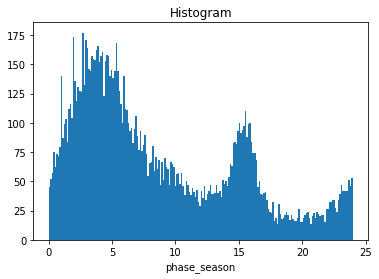

In [42]:
_ = ds_i_season.plot.hist(bins = 200)# plt.xlim([0,6])

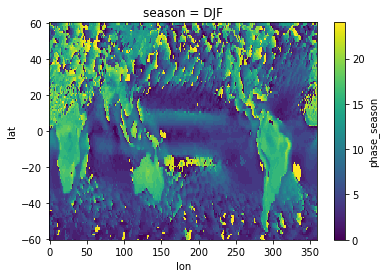

In [103]:
# out_ds['phase_season'].round(round_pres).where(out_ds['phase_season'].round(round_pres) == 24)
# ds_i_season.round(round_pres).where(out_ds['phase_season'].round(round_pres) == 24)
# ds_i_season.round(round_pres).plot.hist

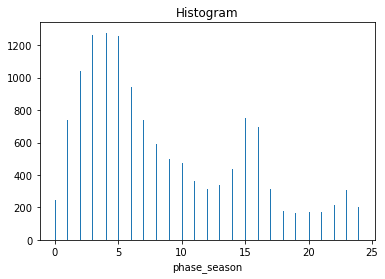

<Figure size 432x288 with 0 Axes>

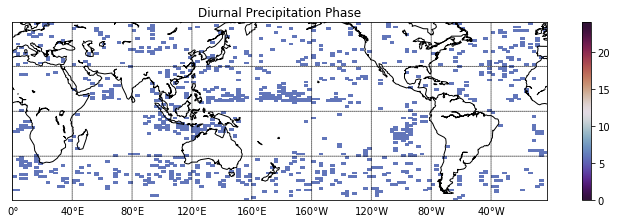

In [43]:
round_pres = 0

plt.figure()
_ =  ds_i_season.round(round_pres).plot.hist(bins = 300)

plt.figure()
make_single_plot(ds_i_season.round(round_pres).where(ds_i_season.round(round_pres) == 6), 
                 title = r'Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

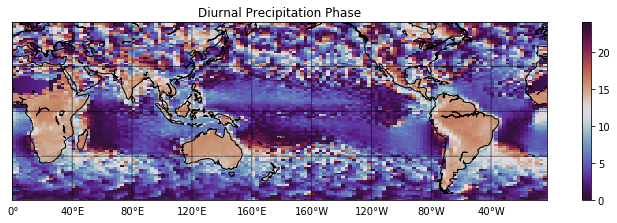

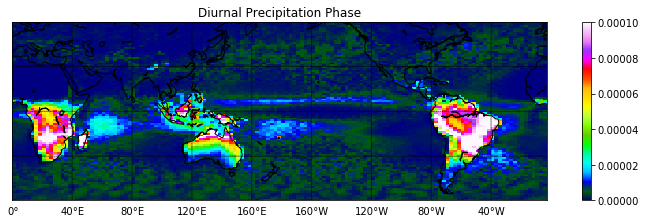

In [8]:
make_single_plot(ds_i_season, 
                 title = r'Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('twilight_shifted'),
                 vmin = 0, vmax = 24)

make_single_plot(ds_i_ampl_season, 
                 title = r'Diurnal Precipitation Phase',
                 cmap = plt.get_cmap('gist_ncar'),
                 vmin = 0, vmax = 0.0001,)
#                  axis = [180, 190, -20, 0])

(0, 0.0002)

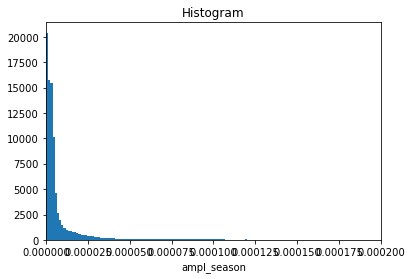

In [82]:
_=ds_i_ampl_season.plot.hist(bins = 400)
plt.xlim([0, 0.0002])

In [40]:
# plt.imshow(ds_i_ampl_season.values, origin = 'lower',
#            cmap = plt.get_cmap('gist_ncar'), vmax = 0.00001)
# plt.colorbar()
# # # plt.axes([280, 290, 30, 50])
# plt.xlim([340, 370])
# # plt.ylim([20, 60])

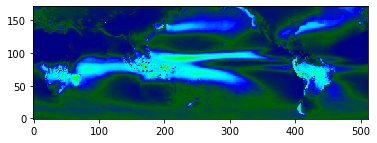

In [43]:
plt.imshow(np.nanmean(hour_means[:,:,:], axis = 0), 
           origin = 'lower', 
           cmap = 'gist_ncar')

# plt.imshow(hour_means[4,:,:], 
#            origin = 'lower', 
#            cmap = 'gist_ncar')

In [89]:
# time_ind = 3
# print(season_ds.isel(time = time_ind))
# dt_i = datetime.strptime(str(season_ds.isel(time = time_ind)['time'].values.item()), '%Y-%m-%d %H:%M:%S')
# # dt_i
# rr = calc_solar_time_ephem(dt_i, lon_mesh, bin_interval = time_resolution_hours, bin_bool = True)
# plt.imshow(rr, origin = 'lower')

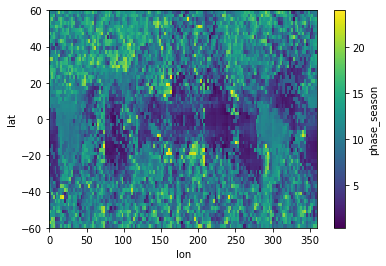

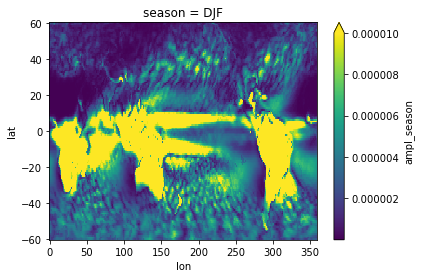

In [182]:
out_ds['ampl_season'].isel(season =0).plot.imshow(vmax = 0.00001)


In [185]:
np.any(np.isnan(out_ds['phase_season']))

<xarray.DataArray 'phase_season' ()>
array(False)

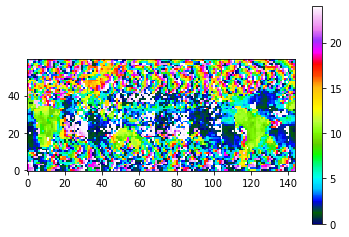

In [222]:
plt.imshow(phase_season['DJF'], origin = 'lower', cmap = plt.get_cmap('gist_ncar'))
plt.colorbar()

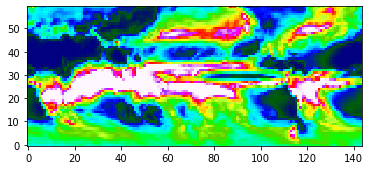

In [227]:
plt.imshow(np.nanmean(hour_means[:,:,:],axis = 0), origin = 'lower', vmax = 0.0001, cmap = plt.get_cmap('gist_ncar'))

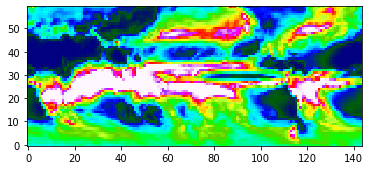

In [228]:
plt.imshow(field_season_mean, origin = 'lower', vmax = 0.0001, cmap = plt.get_cmap('gist_ncar'))

<xarray.DataArray 'time' ()>
array('1985-06-13T13:30:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 1985-06-13T13:30:00
Attributes:
    axis:           T
    standard_name:  time
    long_name:      Time axis
    time_origin:    1850-01-01 00:00:00
    bounds:         time_bounds


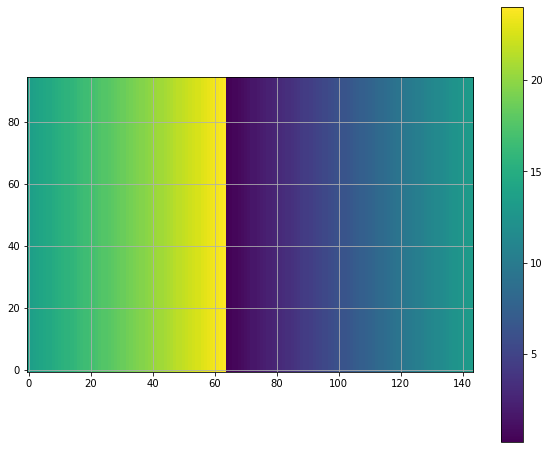

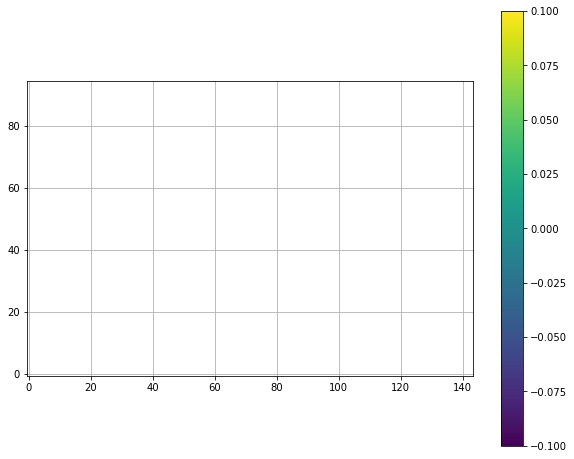

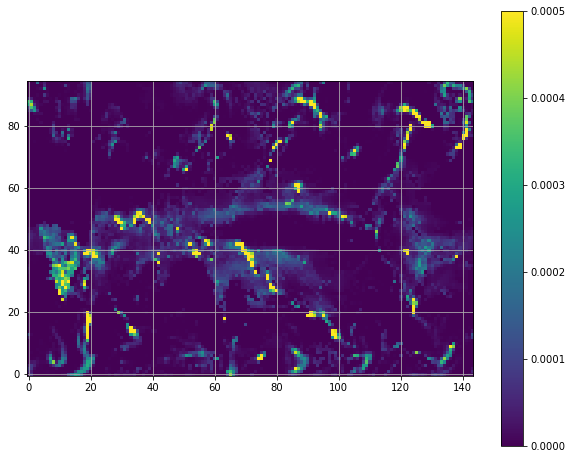

In [233]:
ii = 100

print(season_ds.time[ii])

plt.figure(figsize = (10,8))
plt.imshow(lst_array[ii,:,:], origin = 'lower')
plt.grid()
plt.colorbar()

# plt.fiugre

masked_field_ = np.where(lst_array == 1.2, field_season_array, np.nan)
plt.figure(figsize = (10,8))
plt.imshow(masked_field_[ii,:,:], origin = 'lower', vmax = 0.0005)
plt.grid()
plt.colorbar()


plt.figure(figsize = (10,8))
plt.imshow(field_season_array[ii,:,:], origin = 'lower', vmax = 0.0005)
plt.grid()
plt.colorbar()




In [253]:
np.unique(np.round(lst_array[ii,:,:], 2))

array([ 0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,
        2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,  4.4,
        4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,  6.6,
        6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,  8.8,
        9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ,
       11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. , 13.2,
       13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2, 15.4,
       15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4, 17.6,
       17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6, 19.8,
       20. , 20.2, 20.4, 20.6, 20.8, 21. , 21.2, 21.4, 21.6, 21.8, 22. ,
       22.2, 22.4, 22.6, 22.8, 23. , 23.2, 23.4, 23.6, 23.8, 24. ],
      dtype=float32)

In [254]:
f_bar_ks = {}
for ii in range(len(hour_bins)):
    print(hour_bins[ii])


0.2
0.4
0.6000000000000001
0.8
1.0
1.2
1.4000000000000001
1.6
1.8
2.0
2.2
2.4000000000000004
2.6000000000000005
2.8000000000000003
3.0000000000000004
3.2
3.4000000000000004
3.6000000000000005
3.8000000000000003
4.0
4.2
4.4
4.6000000000000005
4.800000000000001
5.000000000000001
5.2
5.4
5.6000000000000005
5.800000000000001
6.000000000000001
6.2
6.4
6.6000000000000005
6.800000000000001
7.000000000000001
7.2
7.4
7.6000000000000005
7.800000000000001
8.0
8.2
8.4
8.6
8.799999999999999
9.0
9.2
9.4
9.6
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.2
11.4
11.6
11.8
12.0
12.2
12.4
12.6
12.8
13.0
13.2
13.4
13.6
13.8
14.0
14.2
14.4
14.6
14.8
15.0
15.2
15.4
15.6
15.8
16.0
16.2
16.4
16.6
16.8
17.0
17.2
17.4
17.6
17.8
18.0
18.2
18.4
18.6
18.8
19.0
19.2
19.400000000000002
19.6
19.8
20.0
20.2
20.400000000000002
20.6
20.8
21.0
21.2
21.400000000000002
21.6
21.8
22.0
22.2
22.400000000000002
22.6
22.8
23.0
23.2
23.400000000000002
23.6
23.8
24.0


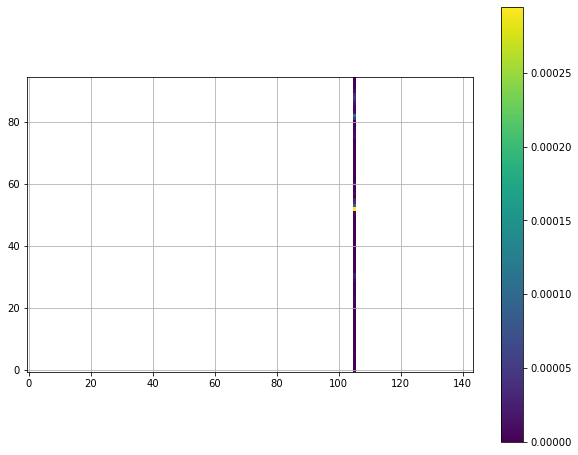

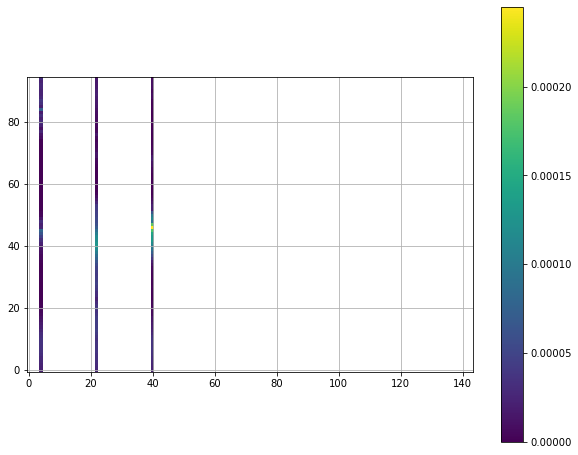

In [192]:
# hour_means.shape
plt.figure(figsize = (10,8))
plt.imshow(hour_means[40,:,:], origin = 'lower')
plt.grid()
plt.colorbar()

In [58]:
# hour_means

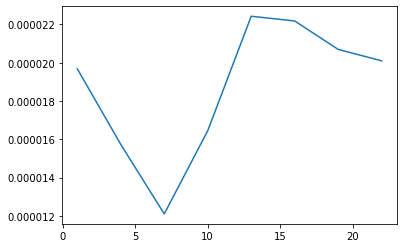

In [55]:
ts_loc_mean_sub = hour_means[:,10,50]
non_nan_inds = np.where(np.isfinite(ts_loc_mean_sub))
plt.plot(hour_bins[non_nan_inds], ts_loc_mean_sub[non_nan_inds])

In [90]:
hour_means.shape

(24, 60, 144)

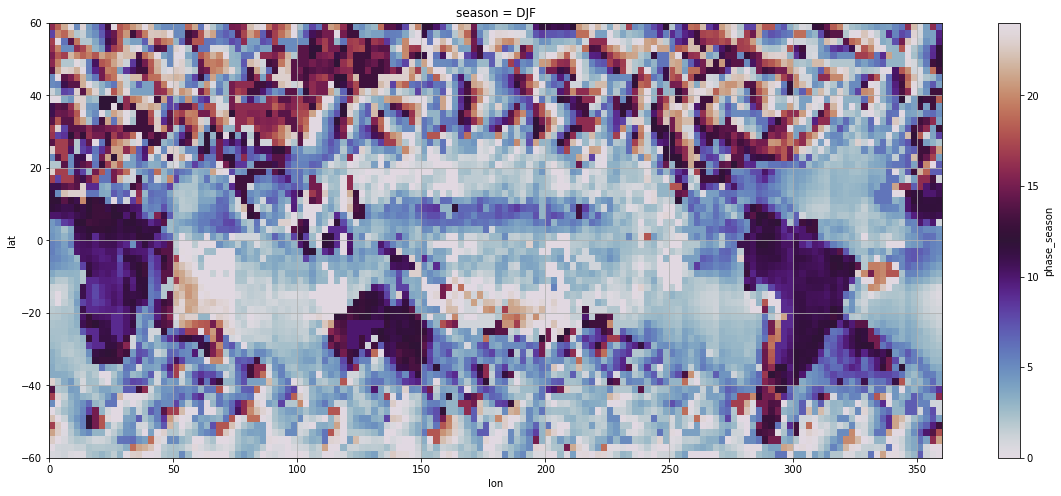

In [162]:
plt.figure(figsize = (20,8))
out_ds.isel(season = 0)['phase_season'].plot.imshow(cmap = plt.get_cmap('twilight'))
plt.grid()

In [156]:
# plt.figure(figsize = (20,8))
# out_ds.mean(dim = 'season')['phase_season'].plot.imshow(cmap = plt.get_cmap('twilight'))
# plt.grid()

20 19
[3.15181101e-06 2.68029503e+00]


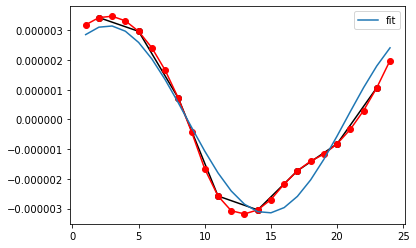

In [145]:
lat_sel = -20
lon_sel = 51

lon_ind = np.argmin(abs(ds['lon'].values - lon_sel))
lat_ind = np.argmin(abs(ds['lat'].values - lat_sel))
print(lon_ind, lat_ind)

ts_loc = hour_means[:,lat_ind,lon_ind]

hours_to_radians = 2*np.pi/24

ts_loc_mean_sub = ts_loc - np.nanmean(ts_loc)
non_nan_inds = np.where(np.isfinite(ts_loc_mean_sub))

f = interpolate.interp1d(hour_bins[non_nan_inds], 
                         ts_loc_mean_sub[non_nan_inds], 
                         kind = 'quadratic',
                         fill_value="extrapolate")

ts_loc_mean_sub_interp = f(hour_bins)

params, params_covariance = optimize.curve_fit(cos_func, 
                                               hour_bins, 
                                               ts_loc_mean_sub_interp,
                                               bounds = (0,24),
                                               p0=[ts_loc_mean_sub_interp.std(), 
                                                   hour_bins[np.nanargmax(ts_loc)]],
                                               maxfev=10000)
plt.plot(hour_bins[non_nan_inds], ts_loc_mean_sub[non_nan_inds], 'ko-')
plt.plot(hour_bins, ts_loc_mean_sub_interp , 'ro-')

print(params)
plt.plot(hour_bins, cos_func(hour_bins, *params), label = 'fit')
plt.legend()

In [145]:
hour_bins[np.nanargmax(ts_loc)]

24

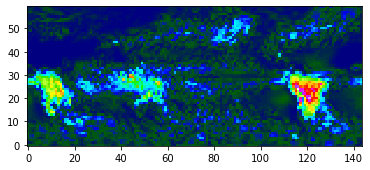

In [10]:
# ts_loc

plt.imshow(res[0], origin = 'lower',
           cmap = plt.get_cmap('gist_ncar'))

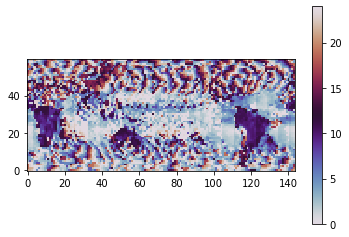

In [15]:
plt.imshow(res[1], origin = 'lower',
           cmap = plt.get_cmap('twilight'), vmin = 0, vmax = 24)
plt.colorbar()
# plt.axis([100, 120,20,30])